In [1]:
import os
import csv
import numpy as np
import pandas as pd
import pyinform as info
import matplotlib as mpl
from matplotlib import pyplot as plt

NOTE: requires use of x86_64 version of python (special conda env) to use `pyinform` library

In [2]:
eeci_colors = ['#E50068','#574145','#009070','#7500a0','#ffbfeb','#00C8A4','#a800e5','#4d4e51','#BEA5A9','#ebf1f7']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=eeci_colors) 

In [3]:
UCam_ids = [0,3,9,11,12,15,16,25,26,32,38,44,45,48,49]
datasets_dir = os.path.join('..','data','analysis','train')
bfile_pattern = 'UCam_Building_%s.csv'

# Comparison of generalisation performance to Mutual Information (between training sets)

In [4]:
# get generalisation performance scores

results_file = os.path.join('..','results', 'prediction_tests_diff-train-test.csv')
gen_results = pd.read_csv(results_file)
mae_results = gen_results[gen_results['Metric']=='gmnMAE']

correlations_dir = os.path.join('..','data','analysis','correlations')
wass_corrs = pd.read_csv(os.path.join(correlations_dir,'wasserstein.csv'),index_col=0)
mae_corrs = pd.read_csv(os.path.join(correlations_dir,'mae.csv'),index_col=0)
rmse_corrs = pd.read_csv(os.path.join(correlations_dir,'rmse.csv'),index_col=0)

models = ['analysis\conv_0',r'analysis\resmlp_0','analysis\linear_0','TFT']
model_names = ['Conv','ResMLP','Linear','TFT']
metric_scores = {}
for model in models:
    metric_scores[model] = [[float(mae_results[(mae_results['Model Name'] == model) & (mae_results['Train Building'] == t_id)]['L%s'%p_id]) for p_id in UCam_ids] for t_id in UCam_ids]

In [5]:
# compute mutual information between training sets

mutual_info_scores = []

for t_id in UCam_ids: # training building
    building_mi_scores = []
    for p_id in UCam_ids: # prediction building
        train_data = pd.read_csv(os.path.join(datasets_dir,bfile_pattern%t_id),usecols=['Equipment Electric Power [kWh]']).to_numpy().flatten()
        predict_data = pd.read_csv(os.path.join(datasets_dir,bfile_pattern%p_id),usecols=['Equipment Electric Power [kWh]']).to_numpy().flatten()
        building_mi_scores.append(info.mutual_info(train_data,predict_data))
    mutual_info_scores.append(building_mi_scores)


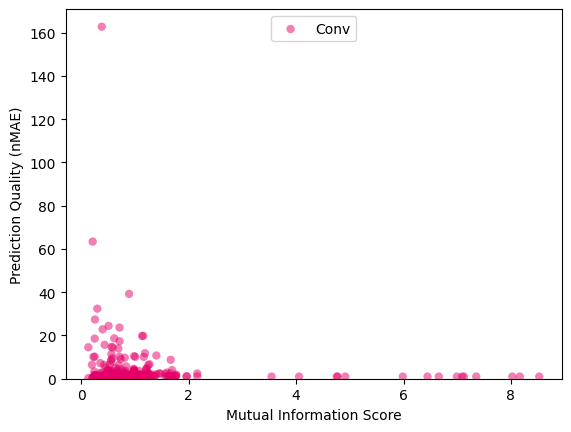

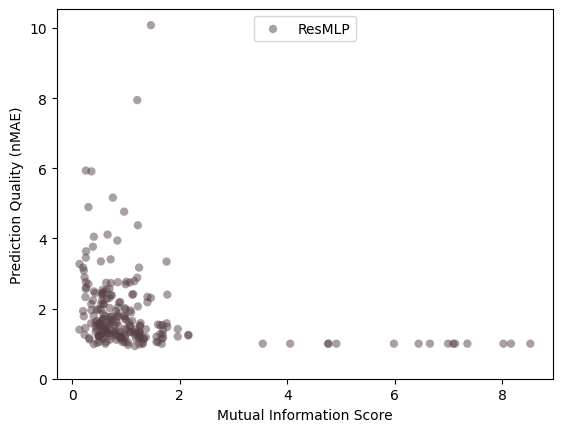

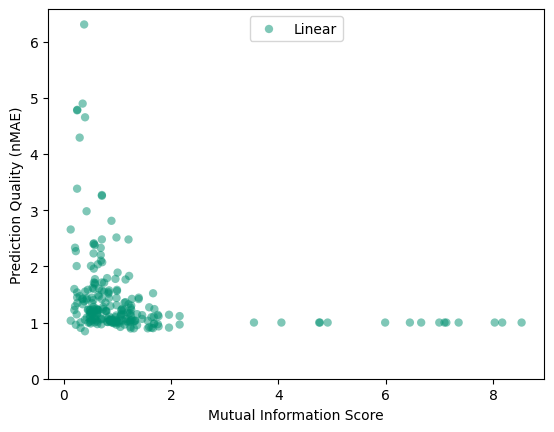

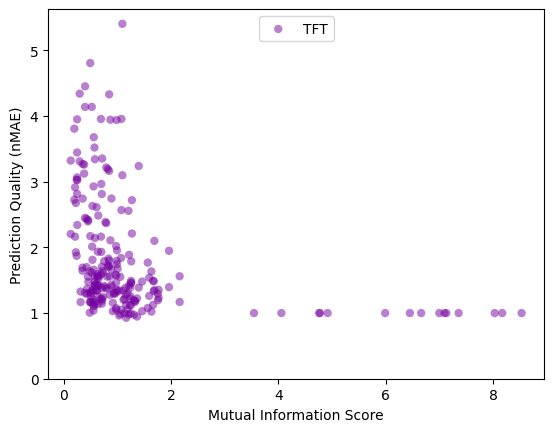

In [6]:
# Plot correlation between generalisation scores and mutual information
for i,model in enumerate(models):
    fig,ax = plt.subplots()
    ax.scatter(np.array(mutual_info_scores).flatten(),np.array(metric_scores[model])/np.diagonal(metric_scores[model]).flatten(),label=model_names[i],color=eeci_colors[i],alpha=0.5,edgecolors='none')
    ax.set_ylim(0)
    ax.set_ylabel('Prediction Quality (nMAE)')
    ax.set_xlabel('Mutual Information Score')
    plt.legend(fancybox=True, loc='upper center')
    plt.show()

# Comparison of generalisation performance to `gzip` compression performance (of contactenated training sets)

In [7]:
import gzip
import struct

In [8]:
# compute gzip compression for concatenated training sets

gzip_compression_scores = []

for t_id in UCam_ids: # training building
    building_gzip_scores = []
    for p_id in UCam_ids: # prediction building
        train_data = pd.read_csv(os.path.join(datasets_dir,bfile_pattern%t_id),usecols=['Equipment Electric Power [kWh]']).to_numpy().flatten()
        predict_data = pd.read_csv(os.path.join(datasets_dir,bfile_pattern%p_id),usecols=['Equipment Electric Power [kWh]']).to_numpy().flatten()

        concat_list = np.concatenate((train_data,predict_data)).tolist()
        data_as_bytes = struct.pack('%sf'%len(concat_list), *concat_list)
        uncomp_size = len(data_as_bytes)
        compressed_bytes = gzip.compress(data_as_bytes)
        comp_size = len(compressed_bytes)

        building_gzip_scores.append(uncomp_size/comp_size)
    gzip_compression_scores.append(building_gzip_scores)

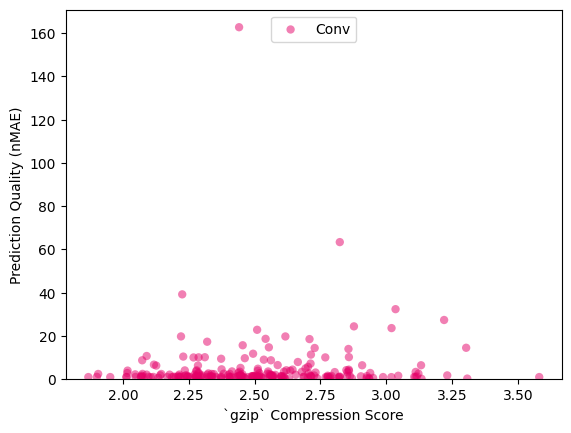

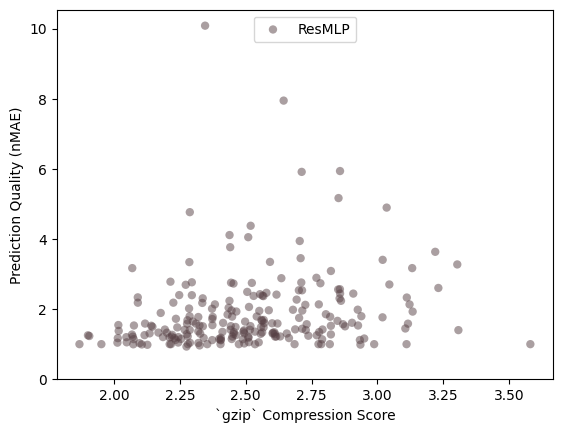

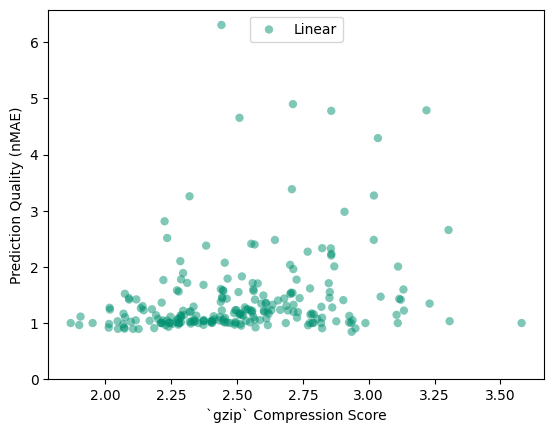

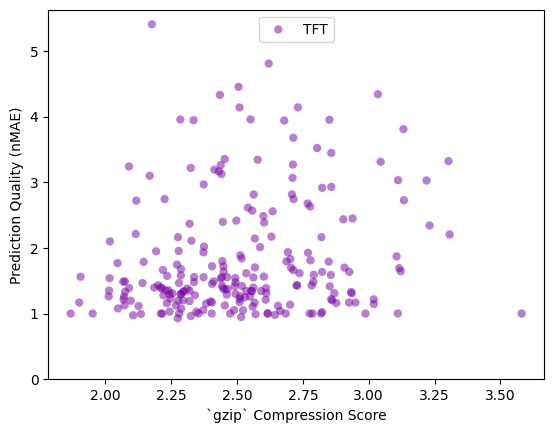

In [9]:
# Plot correlation between generalisation scores and mutual information
for i,model in enumerate(models):
    fig,ax = plt.subplots()
    ax.scatter(np.array(gzip_compression_scores).flatten(),np.array(metric_scores[model])/np.diagonal(metric_scores[model]).flatten(),label=model_names[i],color=eeci_colors[i],alpha=0.5,edgecolors='none')
    ax.set_ylim(0)
    ax.set_ylabel('Prediction Quality (nMAE)')
    ax.set_xlabel('`gzip` Compression Score')
    plt.legend(fancybox=True, loc='upper center')
    plt.show()